The purpose of this script is to find "fads" or "hot topics" in fMRI research over time. It uses Kleinberg's "bursty stream analysis" to identify topics that are uncharacteristically popular during a particular time period. 

The analysis is applied to all articles in the PubMed database that were retrived with the search term "fMRI" and that were published between 01/01/1987 and 11/30/17.

Bursting algorithm:
Kleinberg, 2002. Bursty and Hierarchical Structure in Streams https://www.cs.cornell.edu/home/kleinber/bhs.pdf


### import libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from collections import Counter
from itertools import dropwhile
import string
import re

import burst_detection as bd

import seaborn as sns
import matplotlib.pyplot as plt  
%matplotlib inline

### format plots

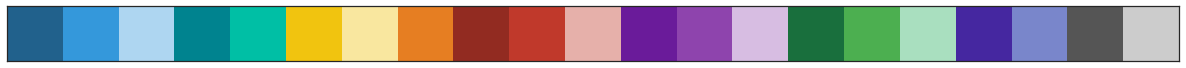

In [2]:
#format plots
sns.set(style='white', context='notebook', font_scale=1.5, 
        rc={'font.sans-serif': 'DejaVu Sans', 'lines.linewidth': 2.5})

#create a custom color palette
palette21 = ['#21618C', '#3498DB', '#AED6F1', '#00838F', '#00BFA5',
             '#F1C40F', '#F9E79F', '#E67E22', '#922B21', '#C0392B', 
             '#E6B0AA', '#6A1B9A', '#8E44AD', '#D7BDE2', '#196F3D', 
             '#4CAF50', '#A9DFBF', '#4527A0', '#7986CB', '#555555', 
             '#CCCCCC']
sns.palplot(palette21)

#create a color map
blog_blue = '#64C0C0'
blue_cmap = sns.light_palette(blog_blue, as_cmap=True)

## Load data and preprocess titles
Data consists of all articles (and review papers) that were returned by searching for 'fMRI OR MRI' in the title/abstract field in the PubMed database. The search was restricted to articles published between 01/01/1987 and 11/30/2017. 410,100 articles meeting these criteria were retrieved on 12/15/2017 and exported to a CSV file.

Data fields:

-- title: title of the article, this will serve as the input for the burst analysis

-- details: journal, publication date, issue, pages, doi, electronic publication (although some articles are missing fields)

*Problem: The formatting of publication dates isn't consistent across articles. The "Details" column includes the journal followed by the publication date (YYYY Mmm DD).

In [3]:
#load the citation information for all fMRI articles into a dataframe
#there are more rows than articles because PubMed inserts header rows into the csv file
data = pd.read_csv('pubmed_result_1987.csv', usecols = ['Title','Details'], index_col=False)
print('Number of rows in dataset: ',len(data))

#remove header rows in the dataset
data = data.loc[data['Details']!='Details',:].reset_index(drop=True)
print('Number of documents in dataset: ',len(data))

#extract the date from the Details string 
#(the publication date is always preceeded by a period and followed by a semi-colon)
data['date'] = data['Details'].apply(lambda x: re.split('[.;:-]',x)[1])

#pull out articles with valid publication dates (year XXXX, month Mmm, and optional day)
#some articles do not have a proper date format (some only have the year,
#   some list a season instead of the month, and some don't list a date at all)
date_format = re.compile(r'^ \d{4} \w{3}$|^ \d{4} \w{3} \d+$')
data = data.loc[data['date'].apply(lambda x: bool(date_format.match(x))),:].reset_index(drop=True)
print('Number of documents with valid date formats: ',len(data))

#convert date to datetime
data['datetime'] = pd.to_datetime(data['date'], format='%Y %b', exact=False)

#remove articles that are not in the time range
data = data.loc[(data['datetime']>=pd.Timestamp('1987-01-01'))&(data['datetime']<pd.Timestamp('2017-11-30')),:] \
           .reset_index(drop=True)
print('Number of valid documents: ',len(data))

#add columns for year and month
data['publication_year'] = data['datetime'].apply(lambda x: x.year)
data['publication_month'] = data['datetime'].apply(lambda x: x.month)

#preprocess words in title: split words, convert to lowercase, and remove punctuation
data['words'] = data['Title'].apply(lambda x: x.lower().split())
data['words'] = data['words'].apply(lambda x: [word.strip(string.punctuation) for word in x])

data.tail()

Number of rows in dataset:  418301
Number of documents in dataset:  410100
Number of documents with valid date formats:  374408
Number of valid documents:  371244


,Title,Details,date,datetime,publication_year,publication_month,words
371239,Measurement of canine left ventricular mass by...,AJR Am J Roentgenol. 1987 Jan;148(1):33-8.,1987 Jan,1987-01-01,1987,1,"[measurement, of, canine, left, ventricular, m..."
371240,Intraabdominal hematoma: the concentric-ring s...,AJR Am J Roentgenol. 1987 Jan;148(1):115-9.,1987 Jan,1987-01-01,1987,1,"[intraabdominal, hematoma, the, concentric-rin..."
371241,Coarctation of the aorta in children undergoin...,Radiology. 1987 Jan;162(1 Pt 1):235-40.,1987 Jan,1987-01-01,1987,1,"[coarctation, of, the, aorta, in, children, un..."
371242,Feasibility of developing a method of imaging ...,Med Biol Eng Comput. 1987 Jan;25(1):2-11. Revi...,1987 Jan,1987-01-01,1987,1,"[feasibility, of, developing, a, method, of, i..."
371243,Whipple's disease confined to the central nerv...,Ann Neurol. 1987 Jan;21(1):104-8.,1987 Jan,1987-01-01,1987,1,"[whipple's, disease, confined, to, the, centra..."


## Create a list of all unique words

In [4]:
#count all words in the fMRI articles titles
word_counts = Counter(data['words'].apply(pd.Series).stack())
print('Number of unique words: ',len(word_counts))

Number of unique words:  101843


In [5]:
#remove words that appear fewer than X times
count_threshold = 50

for key, count in dropwhile(lambda x: x[1] >= count_threshold, word_counts.most_common()):
    del word_counts[key]
print('Number of unique words with at least',count_threshold,'occurances: ',len(word_counts))

Number of unique words with at least 50 occurances:  6310


In [6]:
#create a list of unique words
unique_words = list(word_counts.keys())
unique_words[:10]

['longitudinal',
 'of',
 'endolymphatic',
 'hydrops',
 'in',
 'patients',
 'with',
 'disease',
 'during',
 'medical']

## Calculate proportions of target words across time

Find r and d for each unique word (to make it easier to use later on)
- d: total number of titles per month
- r: number of titles that contain WORD per month


In [7]:
#count the number of articles published each month
d = data.groupby(['publication_year','publication_month'])['words'].count().reset_index(drop=True)

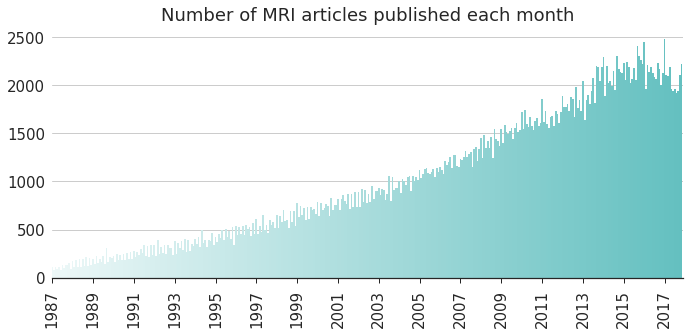

In [8]:
#plot the number of articles published each month

#initialize a figure
plt.figure(figsize=(10,5))

#plot bars
#axes = plt.bar(d.index, d, width=1, color=blue_cmap((d-np.min(d))/(np.max(d)-np.min(d)))) #color according to height
axes = plt.bar(d.index, d, width=1, color=blue_cmap(d.index.values/d.index.max()))  #color according to month

#format plot
plt.grid(axis='y')
plt.xlim(0,len(d))
plt.xticks(range(0,len(d),24), range(1987,2018,2), rotation='vertical')
plt.tick_params(axis='x', length=5)
plt.title('Number of MRI articles published each month')
sns.despine(left=True)

plt.tight_layout()
plt.savefig('fMRI_articles_published_over_time.png', dpi=300)

NOTE: Usually it's better (faster) to create a document x unique_word dataframe where each cell indicates if the WORD is present in the document, and then use groupby to sum the counts for each time period. However, when I used this method, I kept getting a dead kernel. It looks like the issue is that there's not enough memory to make document x unique_word dataframe (which is a ~380000 x ~10000 dataframe). To get around this, I looped across unique words and found the proportion of target words in each month for each target word. It's probably less efficient in most cases where there are fewer documents or unique words, but it works better in this case because we only need to store a month x unique_word dataframe.

In [9]:
#create a dataframe to contain all target word propotions
all_r = pd.DataFrame(columns=unique_words, index=d.index)

#usually it's better (faster) to create a document x unique_word dataframe
#that indicates if the word is in the document all in one step, and then
#use groupby to sum the counts for each time period. However, I kept getting
#a dead kernel and I think the issue was that there wasn't enough memory to 
#store the document x word dataframe.
for i, word in enumerate(unique_words):
    
    all_r[word] = pd.concat([data.loc[:,['publication_year','publication_month']], 
                             data['words'].apply(lambda x: word in x)], 
                            axis=1) \
                    .groupby(by=['publication_year','publication_month']) \
                    .sum() \
                    .reset_index(drop=True)
                
    #print out a status indicator
    if np.mod(i,100)==0:
        print('word',i,'complete')
    
all_r

word 0 complete
word 100 complete
word 200 complete
word 300 complete
word 400 complete
word 500 complete
word 600 complete
word 700 complete
word 800 complete
word 900 complete
word 1000 complete
word 1100 complete
word 1200 complete
word 1300 complete
word 1400 complete
word 1500 complete
word 1600 complete
word 1700 complete
word 1800 complete
word 1900 complete
word 2000 complete
word 2100 complete
word 2200 complete
word 2300 complete
word 2400 complete
word 2500 complete
word 2600 complete
word 2700 complete
word 2800 complete
word 2900 complete
word 3000 complete
word 3100 complete
word 3200 complete
word 3300 complete
word 3400 complete
word 3500 complete
word 3600 complete
word 3700 complete
word 3800 complete
word 3900 complete
word 4000 complete
word 4100 complete
word 4200 complete
word 4300 complete
word 4400 complete
word 4500 complete
word 4600 complete
word 4700 complete
word 4800 complete
word 4900 complete
word 5000 complete
word 5100 complete
word 5200 complete
word 

,longitudinal,of,endolymphatic,hydrops,in,patients,with,disease,during,medical,...,jugulare,stent-graft,mangafodipir,arnold-chiari,angiomas,detachable,thallium-201,spet,hallervorden-spatz,afip
0,0.0,64.0,0.0,0.0,41.0,5.0,17.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,45.0,0.0,0.0,25.0,4.0,20.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,57.0,0.0,0.0,39.0,2.0,14.0,5.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,61.0,0.0,0.0,37.0,4.0,19.0,7.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,76.0,0.0,0.0,37.0,4.0,21.0,6.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,43.0,0.0,0.0,31.0,2.0,17.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,83.0,0.0,0.0,41.0,3.0,17.0,4.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,57.0,0.0,0.0,31.0,1.0,20.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,83.0,0.0,0.0,46.0,3.0,23.0,9.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,64.0,0.0,0.0,52.0,6.0,13.0,3.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#find r and d for each unique word (to make it easier to use later on)
#r: number of titles that contain WORD per month
#d: total number of titles per month

#find d
#d = data.groupby(['publication_year','publication_month'])['words'].count().reset_index(drop=True)

#before finding r, tag the titles that contain the WORD
#(this method ensures r <= d (as opposed to counting the total WORD occurances per month))
#present_words = data['words'].apply(lambda x: pd.Series(word in x for word in unique_words))

#add column names and publication year and month (for grouping)
#present_words.columns = unique_words
#present_words['publication_year'] = data['publication_year']
#present_words['publication_month'] = data['publication_month']

#count the number of titles that contain the WORD for each time period
#all_r = present_words.groupby(['publication_year','publication_month']).sum()

### visualize most common words

In [11]:
def plot_most_common_words(word_counts, n, title, gradient, label_type):
    
    #remove words that relate to MRI and non-content words (like articles and prepositions)
    discard_words = ['of','in','and','the','a','with','for','to','on','an','by','using',
                     'from','as','is','at','between','during',
                     'mr','fmri','magnetic','resonance','imaging','mri']
    for key in discard_words:
        del word_counts[key]
    word_counts = pd.DataFrame(word_counts.most_common()[:n], columns=['word','count'])

    #define colors for bars
    if gradient:
        bar_colors = blue_cmap((word_counts['count'])/(word_counts['count'].max()))
    else:
        bar_colors = blog_blue

    #create a horizontal bar plot
    plt.barh(range(n,0,-1), word_counts['count'], height=0.85, color=bar_colors, alpha=1)

    #format plot
    sns.despine(left=True,bottom=True)
    plt.ylim(0,n+1)
    plt.title(title)
    plt.grid(axis='x')

    #label bars
    if label_type == 'counts':
        plt.yticks(range(n,0,-1), word_counts['word']);
        for i, row in word_counts.iterrows():
            plt.text(row['count']-100,50-i-0.2, row['count'], horizontalalignment='right', fontsize='12', color='white')

    elif label_type == 'labeled_bars_left':
        plt.yticks(range(n,0,-1), []);
        for i, row in word_counts.iterrows():
            plt.text(50,n-i-0.2, row['word'], horizontalalignment='left', fontsize='14')

    elif label_type == 'labeled_bars_right':
        plt.yticks(range(n,0,-1), []);
        for i, row in word_counts.iterrows():
            plt.text(row['count'],n-i-0.2,row['word'], horizontalalignment='right', fontsize='14')

    else:
        plt.yticks(range(n,0,-1), word_counts['word']);



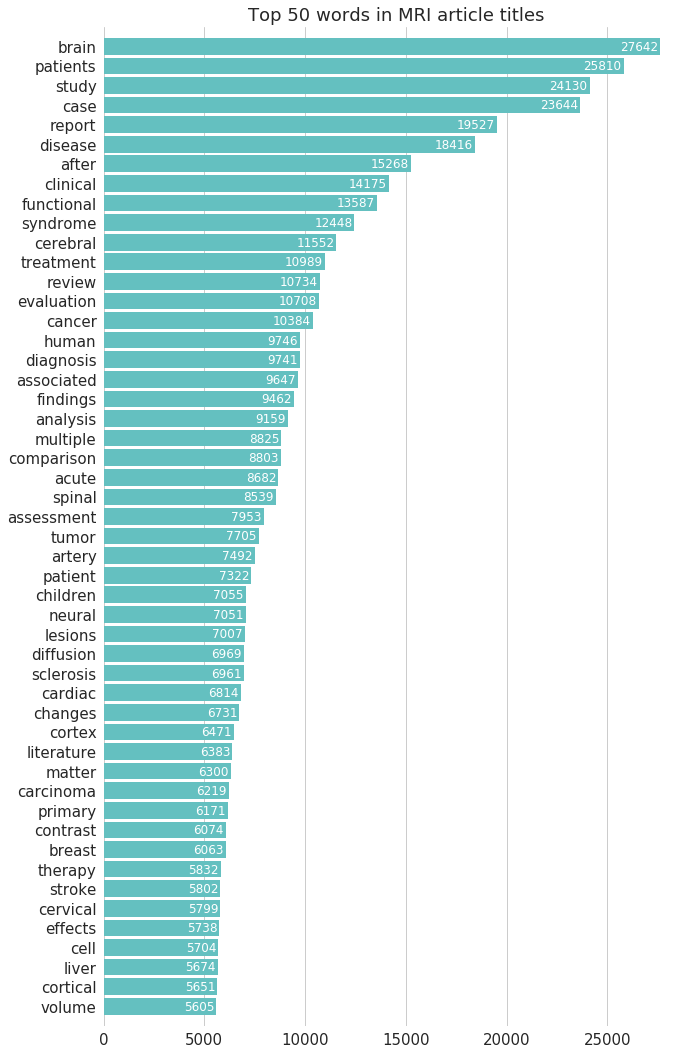

In [12]:
plt.figure(figsize=(10,15))
plot_most_common_words(word_counts=word_counts, n=50, 
                       title='Top 50 words in MRI article titles', 
                       gradient=False, label_type='counts')
plt.tight_layout()
plt.savefig('most_common_words_in_fMRI_titles.png',dpi=300)

### rank most common words for the last 10 years

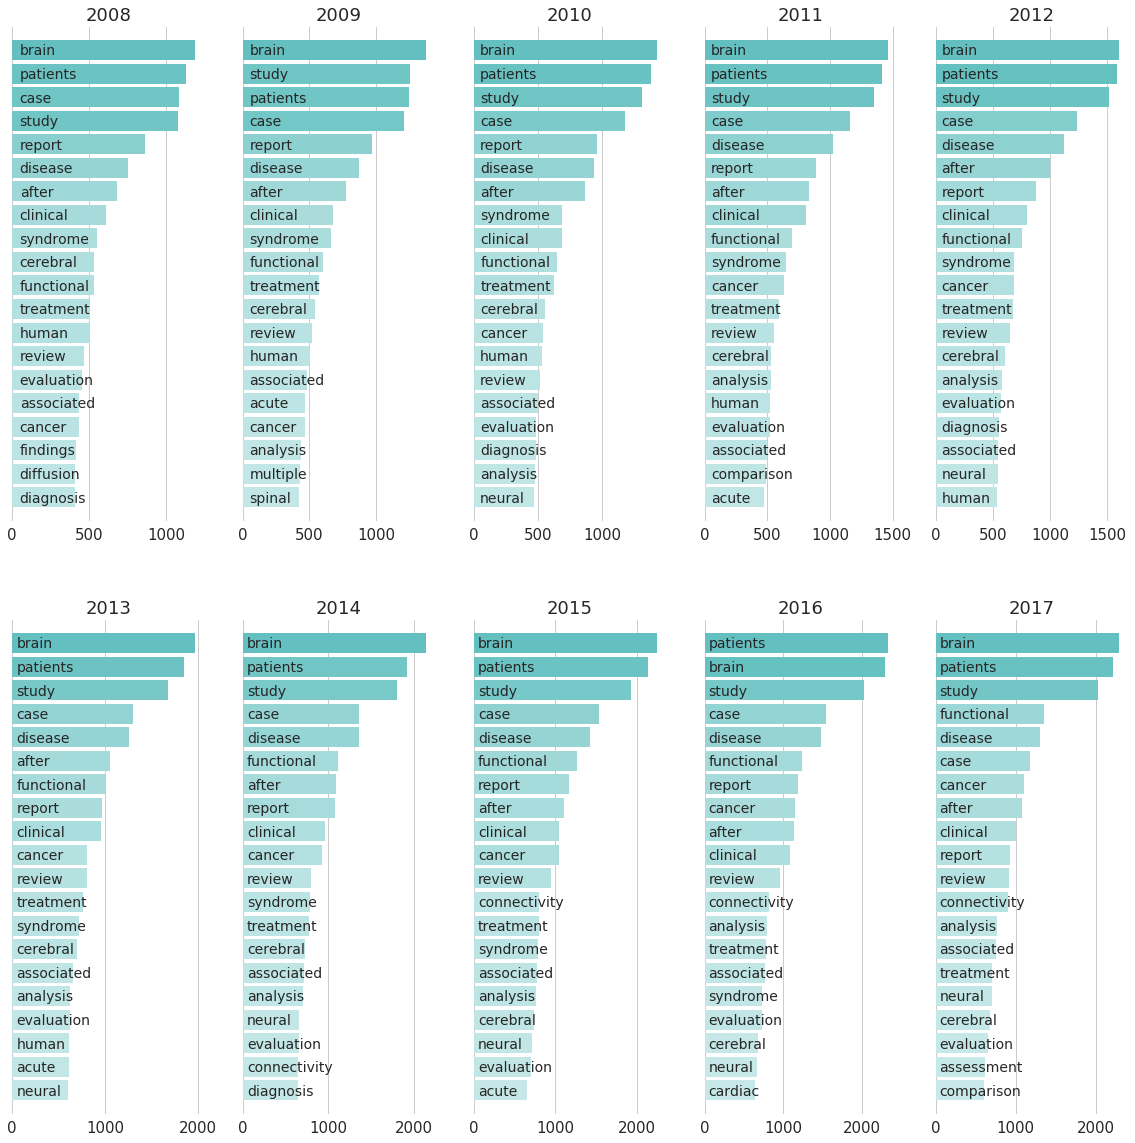

In [13]:
n=20
start_year = 2008

#create subplots
fig, axes = plt.subplots(2,5, figsize=(20,20), sharex=True, sharey=True);

for i, ax in enumerate(axes.flatten()):
    
    plt.subplot(2,5,i+1)
    
    #count words for the year
    year_word_counts = Counter(data.loc[data['publication_year']==start_year+i,'words'].apply(pd.Series).stack())
    
    #plot n most common words
    plot_most_common_words(word_counts = year_word_counts, n=n, 
                           title=str(start_year+i), gradient=True, label_type='labeled_bars_left')

### visualize timecourses of the most common words

In [14]:
start_year = 2007  #time frame start
end_year = 2017    #time frame end

#count all word occurances in the given time frame
word_counts_in_range = Counter(data.loc[(data['publication_year']>=start_year)&(data['publication_year']<=end_year),'words'].apply(pd.Series).stack())

#discard unwanted words
discard_words = ['of','in','and','the','a','with','for','to','on','an','by','using',
                 'from','as','is','at','between','during',
                 'mr','fmri','magnetic','resonance','imaging','mri']
for key in discard_words:
    del word_counts_in_range[key]

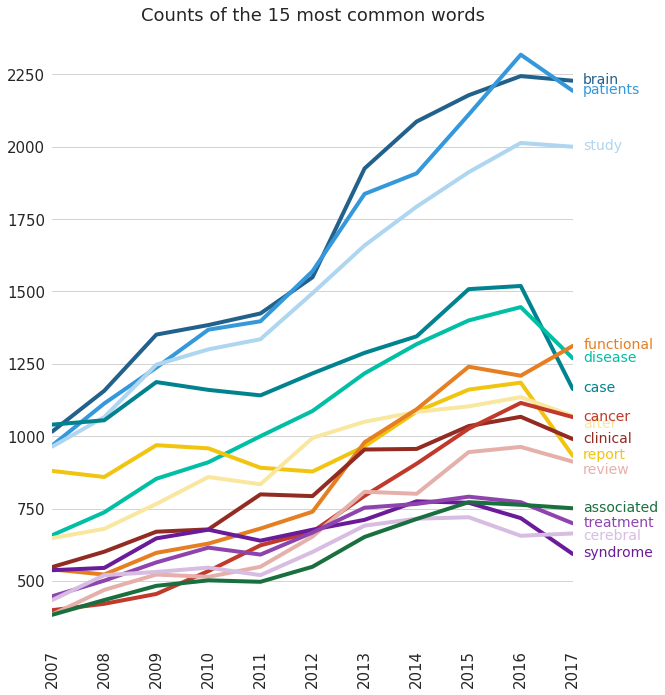

In [15]:
#number of words to plot
n = 15 

#pull out the N most common words and add to a word count dataframe
most_common_word_counts = pd.DataFrame(columns = pd.DataFrame(word_counts_in_range.most_common()[:n])[0],
                                       index = range(start_year,end_year+1))

#pull out counts of most common words for each year in the time frame
for word in most_common_word_counts.columns:
    most_common_word_counts[word] = pd.concat([data['publication_year'], data['words'].apply(lambda x: word in x)], axis=1) \
                                      .groupby(by=['publication_year']) \
                                      .sum()
#initialize plot
plt.figure(figsize=(10,10))

#loop through most common words
for i, word in enumerate(most_common_word_counts.columns):
    
    #plot line
    plt.plot(range(start_year,end_year+1), 
             most_common_word_counts[word], 
             lw=4, color=palette21[i])
    
    #define the position for the label
    y_pos = most_common_word_counts.loc[end_year,word]
    #some labels overlap and need to be defined manually
    if word=='after':
        y_pos = y_pos-30
    if word=='review':
        y_pos = y_pos-30
    if word=='cerebral':
        y_pos = y_pos-10
    
    #plot time series label in the same color
    plt.text(end_year+0.2, y_pos-10, word, fontsize=14, color=palette21[i])
    
#format plot
sns.despine(left=True, bottom=True)
plt.title('Counts of the 15 most common words')
plt.grid(axis='y', color='lightgray')
plt.xticks(range(start_year,end_year+1), range(start_year,end_year+1), rotation='vertical');
plt.xlim(start_year,end_year);

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig('most_common_fMRI_word_in_the_last_10_years.png',dpi=300)

## Find bursts for each unique word

In [16]:
#find bursts

#create a dataframe to hold results
all_bursts = pd.DataFrame(columns=['begin','end','weight'])

#define variables
s = 2         #resolution of state jumps; higher s --> fewer but stronger bursts
gam = 0.5     #difficulty of moving up a state; larger gamma --> harder to move up states, less bursty
n = len(d)    #number of timepoints

#loop through unique words
for i, word in enumerate(unique_words):

    r = all_r.loc[:,word].astype(int)

    #find the optimal state sequence (using the Viterbi algorithm)
    [q,d,r,p] = bd.burst_detection(r,d,n,s,gam,smooth_win=5)

    #enumerate the bursts
    bursts = bd.enumerate_bursts(q, word)

    #find weight of each burst
    bursts = bd.burst_weights(bursts, r, d, p)

    #add the bursts to a list of all bursts
    all_bursts = all_bursts.append(bursts, ignore_index=True)
    
    #print a progress report every 100 words
    if np.mod(i,100)==0:
        print('word',i,'complete')

all_bursts.sort_values(by='weight', ascending=False)

#save bursts to an excel file
#all_bursts.to_excel('fMRI_bursts_5moSmooth_gam0-5_s2.xlsx')

word 0 complete
word 100 complete
word 200 complete
word 300 complete
word 400 complete
word 500 complete
word 600 complete
word 700 complete
word 800 complete
word 900 complete
word 1000 complete
word 1100 complete
word 1200 complete
word 1300 complete
word 1400 complete
word 1500 complete
word 1600 complete
word 1700 complete
word 1800 complete
word 1900 complete
word 2000 complete
word 2100 complete
word 2200 complete
word 2300 complete
word 2400 complete
word 2500 complete
word 2600 complete
word 2700 complete
word 2800 complete
word 2900 complete
word 3000 complete
word 3100 complete
word 3200 complete
word 3300 complete
word 3400 complete
word 3500 complete
word 3600 complete
word 3700 complete
word 3800 complete
word 3900 complete
word 4000 complete
word 4100 complete
word 4200 complete
word 4300 complete
word 4400 complete
word 4500 complete
word 4600 complete
word 4700 complete
word 4800 complete
word 4900 complete
word 5000 complete
word 5100 complete
word 5200 complete
word 

,begin,end,label,weight
71,2,168,mr,2840.99
7,2,73,imaging,1591.27
10,320,368,connectivity,871.084
4,2,71,resonance,703.535
1,2,71,magnetic,689.777
106,2,118,ct,416.095
66,324,368,network,374.381
65,326,368,resting-state,354.472
14,325,368,networks,226.962
21,341,368,cancer,202.833


Notes: Temporal smoothing seems to greatly improve the ability of the algorithm to identify bursts. It makes the interpretation of the burst endpoints tricky though. N is equal to the number of non-nan elements in r.

## plot timeline of top bursts

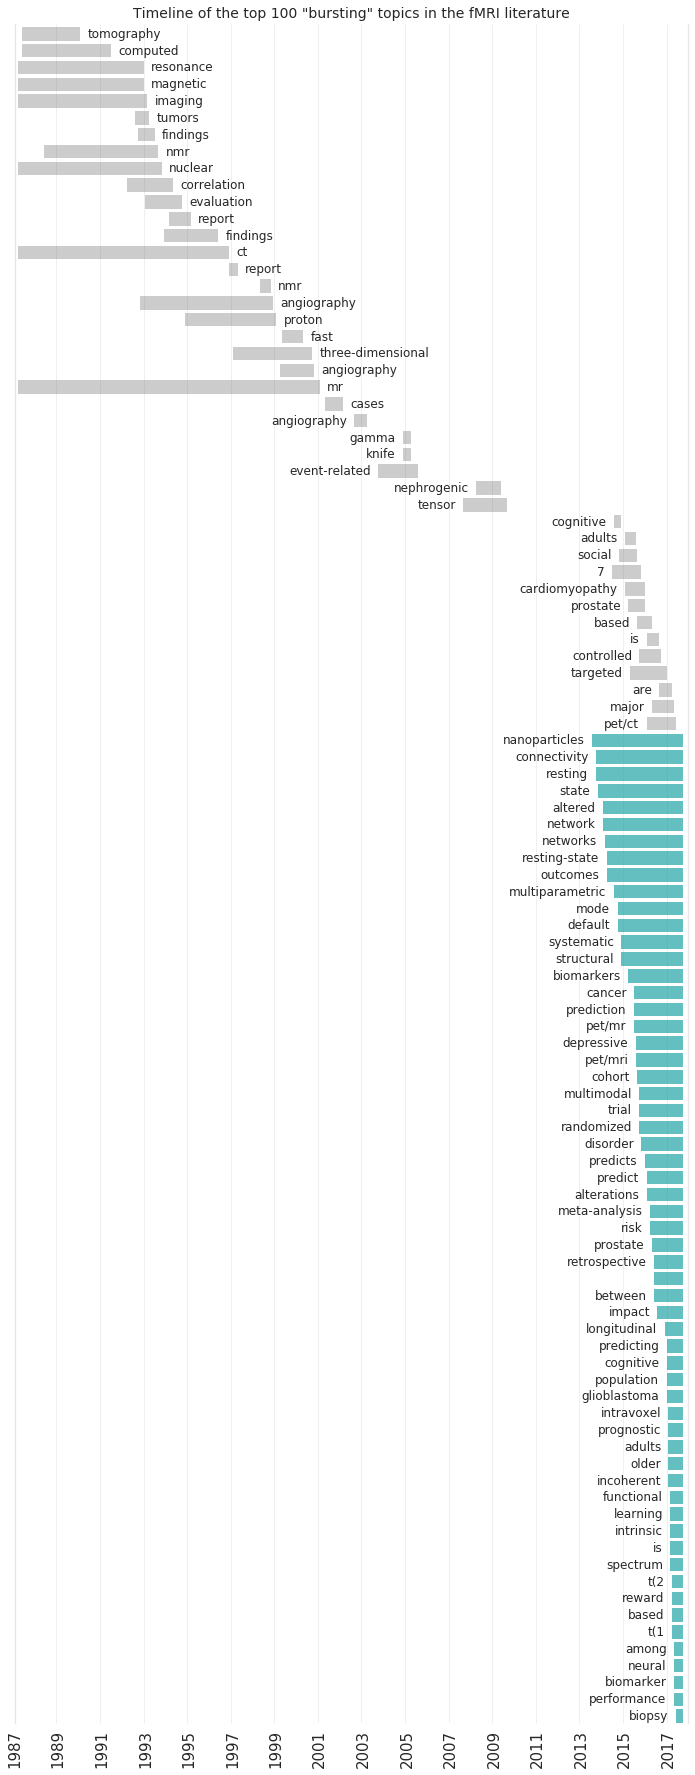

In [17]:
#visualize the bursts

#plot only the n biggest bursts
n_bursts = 100
top_bursts = all_bursts.sort_values(by='weight', ascending=False).reset_index(drop=True).loc[:n_bursts,:]

#sort bursts by end date
sorted_bursts = top_bursts.sort_values('end', ascending=False).reset_index(drop=True)
#for bursts that end at the last timepoint, sort by start point
last_timepoint = np.max(sorted_bursts['end'])
sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] = sorted_bursts.loc[sorted_bursts['end']==last_timepoint,:] \
                                                                         .sort_values(by='begin', ascending=False) \
                                                                         .reset_index(drop=True)
    
#format bars
bar_width = 0.8                                 #width of bars
bar_pos = np.array(range(len(sorted_bursts)))   #positions of top edge of bars
ylabel_pos = bar_pos + (bar_width/2)            #y axis label positions
n = len(d)                                      #number of time points

#initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 25))

#plot current bursts in blue and old bursts in gray
sorted_bursts['color'] = '#CCCCCC' #gray
sorted_bursts.loc[sorted_bursts['end']==last_timepoint,'color'] = blog_blue

#plot the end points
end_bars = ax.barh(bar_pos, sorted_bursts.loc[:,'end'], bar_width, align='edge', 
        color=sorted_bursts['color'], edgecolor='none')

#plot the start points (in white to blend in with the background)
start_bars = ax.barh(bar_pos, sorted_bursts.loc[:,'begin'], bar_width, align='edge', 
        color='w', edgecolor='none')

#label each burst
plt.yticks(ylabel_pos, '') #remove default labels
for burst in range(len(sorted_bursts)):
    width = int(end_bars[burst].get_width())
    #place label on right side for early bursts
    if width <= (n/2):
        plt.text(width+4, ylabel_pos[burst], sorted_bursts.loc[burst,'label'],
                fontsize=12, va='center')
    #place label on left side for late bursts
    else:
        width = int(start_bars[burst].get_width())
        plt.text(width-4, ylabel_pos[burst], sorted_bursts.loc[burst,'label'],
                fontsize=12, va='center', ha='right')
        
#format plot
ax.set(xlim=(0, n), ylim=(0,n_bursts+1), ylabel='', xlabel='')
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_color([0.9, 0.9, 0.9])    
ax.spines["right"].set_color([0.9, 0.9, 0.9])
for x in range(0, n):
    if (x+1)%24 == 0:
        plt.axvline(x,color='gray', linestyle='-', linewidth=0.5, alpha=0.25)
plt.xticks(range(0,n+3,24),range(1987,2018,2),rotation='vertical')

ax.set_title('Timeline of the top ' + str(n_bursts) +' "bursting" topics in the fMRI literature', size=14)
plt.tight_layout()
plt.savefig("bursts_top100_g0-5_s2.png", bbox_inches="tight", dpi=300)


## plot heatmap of normalized proportions over time

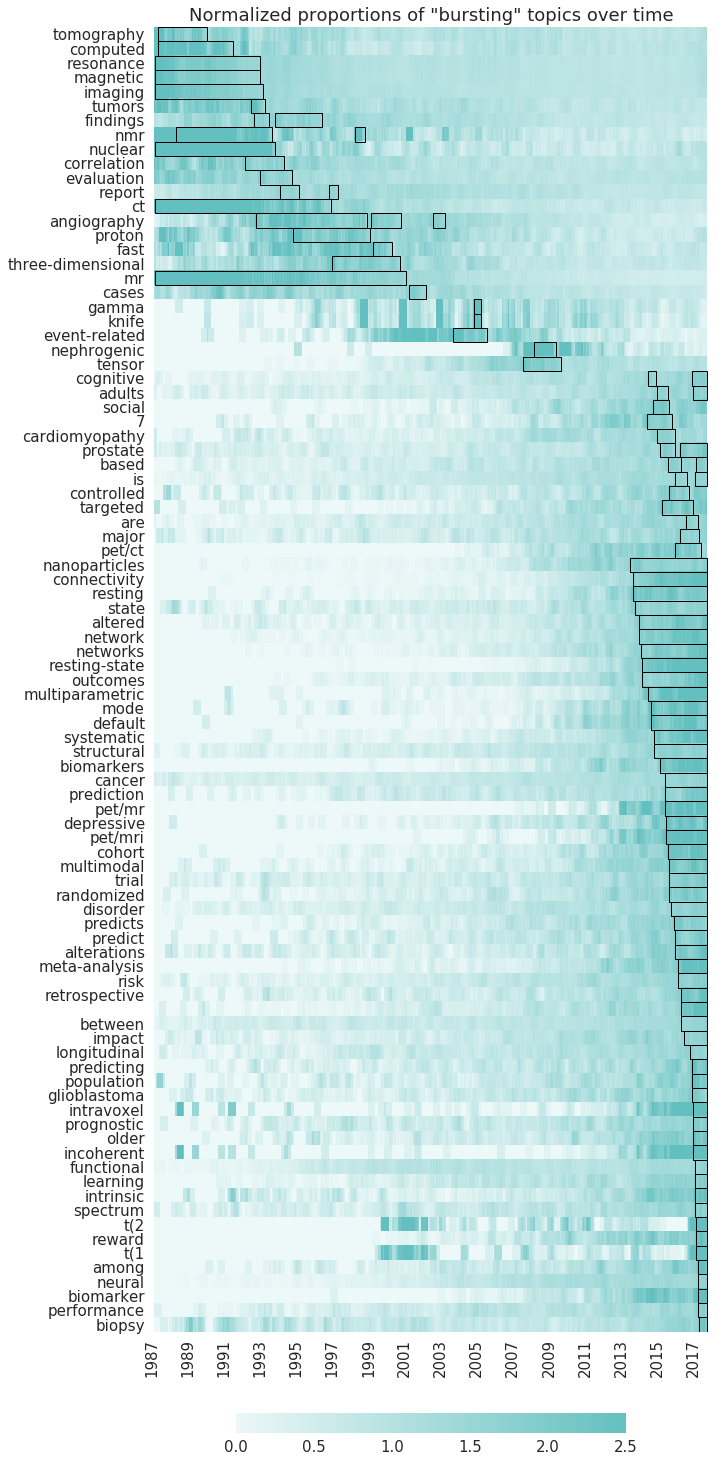

In [18]:
#create a heatmap of p vs. time for the bursting words

#pull out the r values that will be displayed
heatmap_data = all_r.loc[:,set(sorted_bursts['label'])]

#find the baseline proportions sum(r)/sum(d) for each label
baseline_p = heatmap_data.sum(axis=0) / d.sum()

#convert r values into proportions at each timepoint
heatmap_data = heatmap_data.apply(lambda x: x/d)

#sort the rows according to the order used in the timeline
order = sorted_bursts['label'].drop_duplicates(keep='last').values
#transpose data and reindex the data according to the sorted word order
heatmap_data = heatmap_data.T.reindex(order)

#optional: demean proportions
#heatmap_data = heatmap_data - heatmap_data.mean(axis=1)

#optional: convert proportions into multiples of the baseline proportion
heatmap_data = heatmap_data.apply(lambda x: x/baseline_p[x.index])

#smooth proportions with the same smoothing window used in burst detection
smoothed_heatmap_data = heatmap_data.rolling(window=5, center=True, axis=1).mean()

#create the heatmap
plt.figure(figsize=(10,30))
ax = sns.heatmap(smoothed_heatmap_data[::-1], vmin=0, vmax=2.5, cmap=blue_cmap, yticklabels=True,
                 cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.05, shrink=0.7))
plt.title('Normalized proportions of "bursting" topics over time')
plt.xticks(range(0,n,24), range(1987,2018,2), rotation='vertical')

#create boxes around bursting periods
for index, burst in sorted_bursts.iterrows():
        
    #define outline positions
    y = smoothed_heatmap_data.index.get_loc(burst['label'])
    y = len(smoothed_heatmap_data) - y - 1 #reverse since it counts from bottom
    xstart = burst['begin'] 
    width = burst['end'] - burst['begin'] + 1
    
    #draw rectangle
    ax.add_patch(plt.Rectangle((xstart,y), width, height=1, alpha=1, 
                           facecolor='none', edgecolor='k', linewidth=1))

#plt.savefig("heatmap.png", bbox_inches="tight", dpi=300)

## find "trending" words

In [19]:
#find words with upward trends

#create a dataframe to hold the slopes of the word counts
word_trends = pd.DataFrame(columns=['m','baseline_prop'], index=unique_words)

#last n months
period_start = pd.Timestamp('2002-01-01')

#denote which months to include in the analysis
months_index = data.groupby(by=['datetime']).count().reset_index()['datetime']
months = months_index >= period_start

#loop through words
for word in unique_words:
    
    #pull out proportion of titles with WORD throughout the whole time period
    word_trends.loc[word,'baseline_prop'] = np.sum(all_r[months][word]) / np.sum(d[months])

    #find the proporitions of titles with WORD for each month 
    prop =  all_r[months][word] / d[months]
    
    #normalize the proportions 
    norm_prop = prop / word_trends.loc[word,'baseline_prop']

    #find the slope of the proportions over time by taking the line of best fit
    word_trends.loc[word,'m'] = stats.linregress(range(sum(months)),norm_prop)[0]

word_trends.sort_values(by='m', ascending=False).head(20)

,m,baseline_prop
pi-rads,0.0194968,0.00018585
gaming,0.0166858,0.000216262
connectome,0.0165852,0.000648787
dual-modal,0.0165756,0.000239916
photothermal,0.0159828,0.00041225
incoherent,0.0159576,0.00093601
theranostics,0.0158532,0.000280465
2014,0.0156492,0.000172334
theranostic,0.0153309,0.000689336
multi-parametric,0.0153017,0.000405492


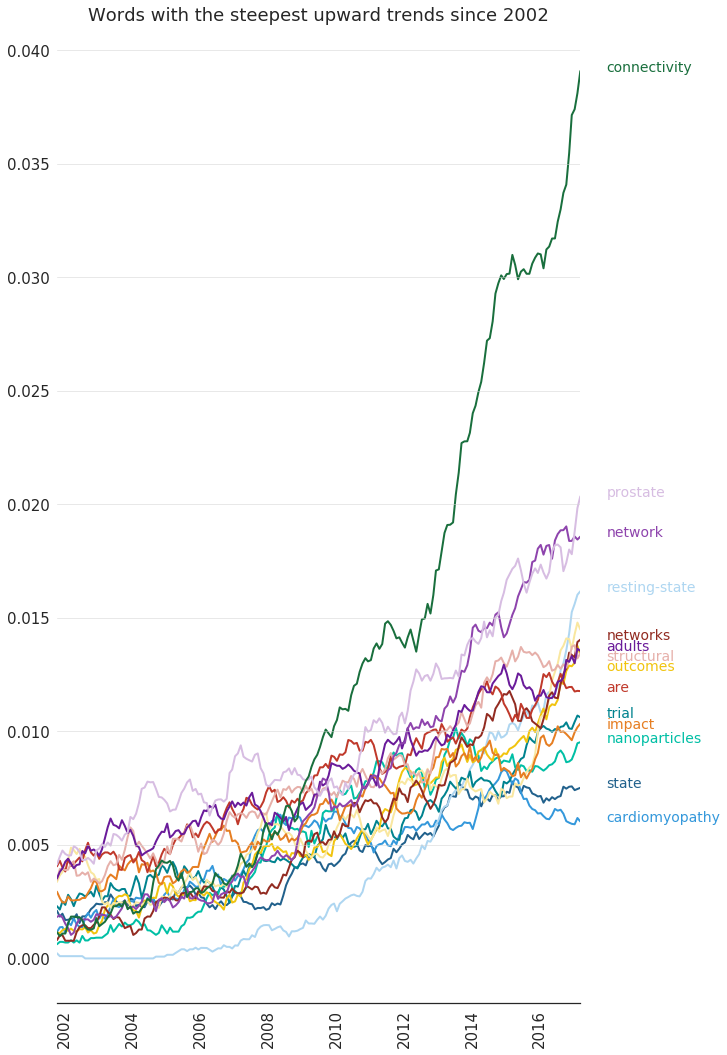

In [20]:
#visualize the time courses of the top trending words

top_n = 15      #number of words to include in the plot
win = 11        #width of smoothing window for plotting; 1 for no smoothing

#pull out the top trending words and their slopes
#only use words with a baseline proportion of at least 0.01
trending_words_p = word_trends.loc[word_trends['baseline_prop']>0.005,:]
#select top n words with steepest slopes
top_words = trending_words_p.sort_values(by='m', ascending=False).iloc[0:top_n,:]

#set up the plot
fig, ax = plt.subplots(figsize=(10, 15))  
  
#plot time series of trending words
for pos, word in enumerate(top_words.sort_values(by='baseline_prop').index):
    
    #calculate p
    p = (all_r.loc[:,word]/d)
    
    #smooth p to aid visualization
    p = p.rolling(window=win, center=True).mean()

    #plot time series
    plt.plot(months_index[months], p[months].values,lw=2, color=palette21[pos])   
    
    #define the position for the label
    y_pos = p[~np.isnan(p)][-1:] #final proportion
    x_pos = ax.get_xlim()[1]     #right of plot
    #some labels overlap and need to be defined manually
    if word=='impact':
        y_pos = y_pos-0.0002
    if word=='structural':
        y_pos = y_pos-.0003
    if word=='outcomes':
        y_pos = y_pos-.0007
    #if word=='measurement':
    #    y_pos = y_pos-0.0001
    #if word=='pilot':
    #    y_pos = y_pos-0.0002
    #if word=='adolescents':
    #    y_pos = y_pos-.0002
    #if word=='prognostic':
    #    y_pos = y_pos-.0003
    #if word=='mutation':
    #    y_pos = y_pos-.001
    #if word=='cord':
    #    y_pos = y_pos+.0002
    #if word=='fat':
    #    y_pos = y_pos+.0001
    #plot time series label in the same color
    plt.text(x_pos, y_pos, word, fontsize=14, color=palette21[pos])  
    
#add a title
plt.title('Words with the steepest upward trends since 2002')

#remove left axis
sns.despine(left=True)

#restrict the x axis to the smoothed window
ax.set_xlim(period_start,(months_index[-1:]-pd.DateOffset(months=(win-1)//2)).values)
#format the xticks
plt.gcf().autofmt_xdate(rotation='vertical', ha='left')

#convert the y axis labels to percentages
#yticks = np.arange(0.005,ax.get_ylim()[1],0.005)
#ylabels = ax.get_yticks()
#ax.set_yticklabels(['{:2.2f}%'.format(y*100) for y in ylabels])

#add horizontal gridlines
for y in np.arange(0.005,ax.get_ylim()[1],0.005):
    plt.axhline(y, color='lightgray', linestyle='-', linewidth=1, alpha=0.5)

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig("trending_words_since_2002.png", bbox_inches="tight", dpi=300)


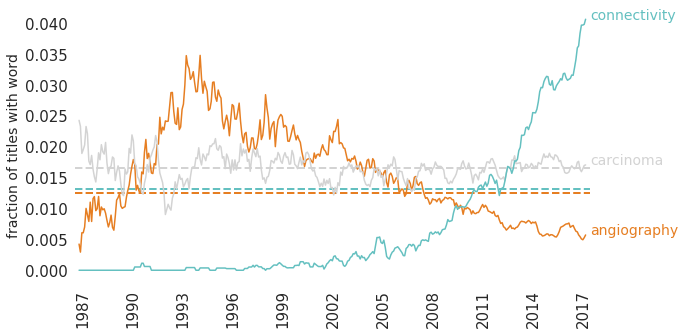

In [21]:
#visualize time courses of representative words as an example

#initialize plot
plt.figure(figsize=(10,5))
plt.gca().set_xlim(months_index[:1].values,months_index[-1:].values)

words = ['angiography', 'carcinoma', 'connectivity']
colors = [palette21[7], 'lightgray', blog_blue]

for i, word in enumerate(words):
    
    #plot proportions
    plt.plot(months_index, (all_r.loc[:,word] / d).rolling(window=7,center=True).mean(), 
             lw=1.5, color=colors[i])
    #plot label
    plt.text(plt.gca().get_xlim()[1], 
             (all_r.loc[:,word] / d).rolling(window=7,center=True).mean()[-4:-3], 
             word, 
             fontsize=14, color=colors[i])
    #plot line at baseline proportion
    plt.axhline(y=np.sum(all_r.loc[:,word])/np.sum(d), ls='--', lw=2, color=colors[i], zorder=0)


sns.despine(left=True, bottom=True)
plt.gca().set_xticks(months_index[::36].values);
plt.gcf().autofmt_xdate(rotation='vertical', ha='left')
plt.gca().set_ylabel('fraction of titles with word', fontsize=14)

plt.tight_layout(rect=[0,0,0.85,1])
plt.savefig('proportions_of_representative_words.png', dpi=300)